<a href="https://colab.research.google.com/github/tonyscan6003/CE6003/blob/master/CE6003_example_1_4_keypoint_matching.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Feature Matching with SIFT Keypoint Descriptor

In this notebook we will use the OpenCV Implementation of the SIFT Detector and Keypoint Descriptor to demonstrate Keypoint Matching with OpenCV functions.



We must install a previous version of OpenCV in order to access the SIFT algorithm.

**Housekeeping**: Import Libraries (including previous version of opencv in order to access the SIFT algorithm), define helper functions

In [1]:
! yes | pip3 uninstall opencv-python

! yes | pip3 uninstall opencv-contrib-python

! yes | pip3 install opencv-python==3.4.2.16
 
! yes | pip3 install opencv-contrib-python==3.4.2.16

Uninstalling opencv-python-4.1.2.30:
  Would remove:
    /usr/local/lib/python3.6/dist-packages/cv2/*
    /usr/local/lib/python3.6/dist-packages/opencv_python-4.1.2.30.dist-info/*
Proceed (y/n)?   Successfully uninstalled opencv-python-4.1.2.30
Uninstalling opencv-contrib-python-4.1.2.30:
  Would remove:
    /usr/local/lib/python3.6/dist-packages/opencv_contrib_python-4.1.2.30.dist-info/*
Proceed (y/n)?   Successfully uninstalled opencv-contrib-python-4.1.2.30
     |████████████████████████████████| 25.0MB 1.4MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
     |████████████████████████████████| 30.6MB 157kB/s 


In [2]:
import numpy as np
import urllib.request
import cv2
import numpy as np
from matplotlib import pyplot as plt
import math
from mpl_toolkits import mplot3d
from scipy import signal

def url_to_image(url):
	resp = urllib.request.urlopen(url)
	temp_image = np.asarray(bytearray(resp.read()), dtype="uint8")
	temp_image = cv2.imdecode(temp_image, cv2.IMREAD_COLOR)
	temp_image = cv2.cvtColor(temp_image, cv2.COLOR_BGR2RGB) # OpenCV defaults to BGR, but we need RGB here..
	return temp_image

#Function to 
def read_images():
    image = url_to_image(image_url)
    x,y,z = np.shape(image)
    # Take Centre Crop (zoomed image)
    x_trg = int(x*scale_factor)
    y_try = int(y*scale_factor)
    bdx = int((x-x_trg)//2)
    bdy = int((y-x_trg)//2)
    image_crop = image[bdx:x-bdx,bdy:y-bdy]
    # Resize original iamge to match cropsize.
    x,y,z = np.shape(image_crop)
    image_scale = cv2.resize(image, dsize=(x, y), interpolation=cv2.INTER_CUBIC)
    return image_scale,image_crop
  

#Read Image:
Read Image from URL and produced two scaled versions for keypoint matching.

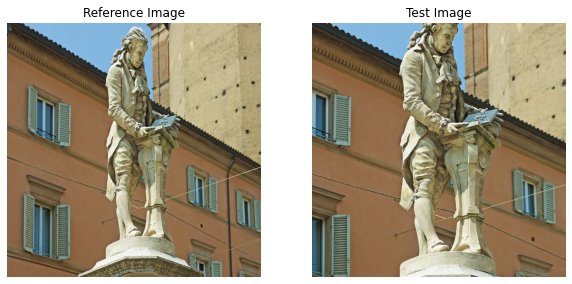

In [3]:
# Image ULR (This can be changed to any image)
#image_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/8/8a/Monarch_butterfly_in_BBG_%2884685%29.jpg/1280px-Monarch_butterfly_in_BBG_%2884685%29.jpg"
image_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/2/2a/Bologna_Statue_of_Galvani.jpg/1280px-Bologna_Statue_of_Galvani.jpg"
#Read in images
scale_factor = 0.85
ref_image,test_image = read_images()

# Plot reference and test images
f, axarr = plt.subplots(1,2,figsize=(10,20))
axarr[0].imshow(ref_image)
axarr[0].axis('off') 
axarr[0].title.set_text('Reference Image')
axarr[1].imshow(test_image)
axarr[1].axis('off') 
axarr[1].title.set_text('Test Image')


#SIFT Descriptor

Instantiate the OpenCV implementation of the SIFT detector/descriptor

This performed using `cv2.xfeatures2d.SIFT_create(nfeatures=50)` where the number of features to return can be adjusted. (lower numbers are perferred for this demo so that correspondances between keypoints can be seen in the images)

The keypoint locations and descriptor vectors are returned using sift.`detectAndCompute(img1,None)`


In [4]:
# Convert images to grey scale
img1 = cv2.cvtColor(ref_image, cv2.COLOR_BGR2GRAY)
img2 = cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY)

# Initiate SIFT
sift = cv2.xfeatures2d.SIFT_create(nfeatures=50)  
# find the keypoints and descriptors with ORB
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

The location of the keypoints on the reference and test images are plotted.

Number of Keypoints Detected In The Training Image:  50
Number of Keypoints Detected In The Query Image:  50


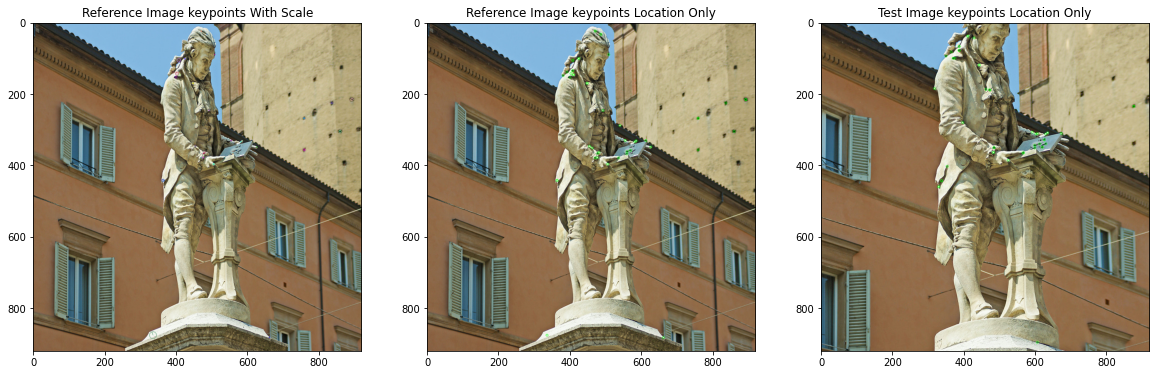

In [5]:
keypoints_without_size = np.copy(ref_image)
testkp_without_size = np.copy(test_image)
keypoints_with_size = np.copy(ref_image)

cv2.drawKeypoints(ref_image, kp1, keypoints_without_size, color = (0, 255, 0))
cv2.drawKeypoints(test_image, kp2, testkp_without_size, color = (0, 255, 0))
cv2.drawKeypoints(ref_image, kp1, keypoints_with_size, flags = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)


# Display image with and without keypoints size
fx, plots = plt.subplots(1, 3, figsize=(20,10))

plots[0].set_title("Reference Image keypoints With Scale")
plots[0].imshow(keypoints_with_size, cmap='gray')

plots[1].set_title("Reference Image keypoints Location Only")
plots[1].imshow(keypoints_without_size, cmap='gray')

plots[2].set_title("Test Image keypoints Location Only")
plots[2].imshow(testkp_without_size, cmap='gray')

# Print the number of keypoints detected in the training image
print("Number of Keypoints Detected In The Training Image: ", len(kp1))

# Print the number of keypoints detected in the query image
print("Number of Keypoints Detected In The Query Image: ", len(kp2))

Keypoint Matching between the descriptors is performed using the openCV brute force matcher (cv2.BFMatcher), this uses k-nearest neighbours algorithm to find correspondences between keypoints from the different images. 

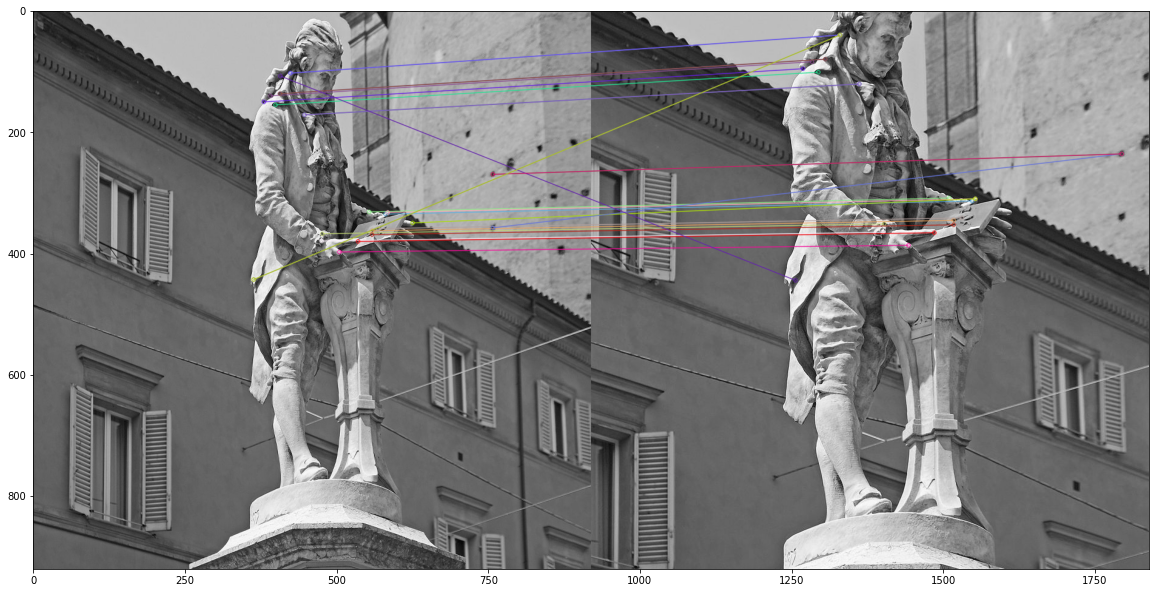

(<matplotlib.image.AxesImage at 0x7ff828a76cc0>, None)

In [6]:
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1,des2,k=2)

# Apply ratio test
good = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        good.append([m])
# cv.drawMatchesKnn expects list of lists as matches.
img3 = cv2.drawMatchesKnn(img1,kp1,img2,kp2,good,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize=(20,20))
plt.imshow(img3),plt.show()
#See the result below: